In [1]:
# Deep learning DTU course 2023
# Fredrik Johansson s213059
# 

In [ ]:

# Imports

import os
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch.optim as optim
from math import cos,sin,asin,sqrt,radians

from torchviz import make_dot


In [2]:
os.system("rm demofile2.txt")
f = open("demofile2.txt", "w")

In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Some general variables
#cost=0
#bikestomove=4 # how many bikes to move at a time in the generic rebalancing algoritm



In [5]:
# Loading of data

# The main data into a dataframe
df = pd.read_csv('test.csv')
# We need to delete the trips that are from the same station to the same station

# We drop trips that are to and from the same station, perhaps they are when users failed to make a trip
for i in range(len(df)):
    try:
        if df.iloc[i]['to_station_id']==df.iloc[i]['from_station_id']:
            try:
                df.drop(i,axis=0,inplace=True)
            except:
                a=1
    except:
       a=1 
    
df.reset_index(inplace=True)


In [6]:
# Conversion from farenheit to Kelvin
df.loc[df["windchill"]==-999, "temperature"] = (df.loc[df["windchill"]==-999, 'temperature']-32) * (5/9)+273.15


In [7]:
# Normalizing of the temperature
column = 'temperature'
df_min_max_scaled = df.copy()
df_min_max_scaled[column]=(df_min_max_scaled[column]-df_min_max_scaled[column].min())/(df_min_max_scaled[column].max()-df_min_max_scaled[column].min())

df=df_min_max_scaled

In [8]:
column = 'precipitation'
df_min_max_scaled = df.copy()
df_min_max_scaled[column]=(df_min_max_scaled[column]-df_min_max_scaled[column].min())/(df_min_max_scaled[column].max()-df_min_max_scaled[column].min())

df=df_min_max_scaled

In [9]:
column = 'dewpoint'
df_min_max_scaled = df.copy()
df_min_max_scaled[column]=(df_min_max_scaled[column]-df_min_max_scaled[column].min())/(df_min_max_scaled[column].max()-df_min_max_scaled[column].min())

df=df_min_max_scaled

In [10]:
column = 'humidity'
df_min_max_scaled = df.copy()
df_min_max_scaled[column]=(df_min_max_scaled[column]-df_min_max_scaled[column].min())/(df_min_max_scaled[column].max()-df_min_max_scaled[column].min())

df=df_min_max_scaled

In [11]:
column = 'wind_speed'
df_min_max_scaled = df.copy()
df_min_max_scaled[column]=(df_min_max_scaled[column]-df_min_max_scaled[column].min())/(df_min_max_scaled[column].max()-df_min_max_scaled[column].min())

df=df_min_max_scaled

In [12]:
#plt.plot(df['temperature'])

In [13]:
print(df.columns)

Index(['index', 'trip_id', 'usertype', 'gender', 'starttime', 'stoptime',
       'tripduration', 'from_station_id', 'from_station_name',
       'latitude_start', 'longitude_start', 'dpcapacity_start',
       'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end',
       'dpcapacity_end', 'temperature', 'windchill', 'dewpoint', 'humidity',
       'pressure', 'visibility', 'wind_speed', 'precipitation', 'events',
       'rain', 'conditions'],
      dtype='object')


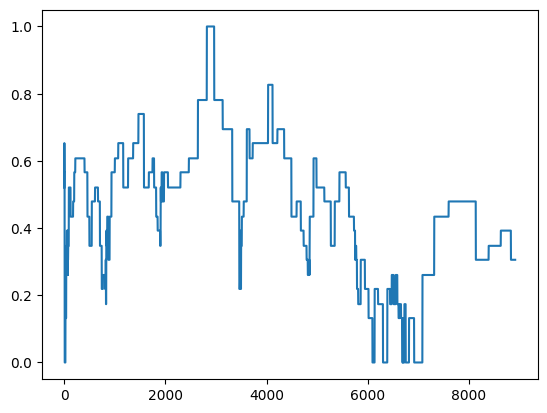

In [14]:
plt.plot(df['wind_speed'])

In [15]:
df

,index,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,from_station_name,latitude_start,...,windchill,dewpoint,humidity,pressure,visibility,wind_speed,precipitation,events,rain,conditions
0,0,4118,Customer,NaN,2013-06-27 12:11:00,2013-06-27 12:16:00,316,85,Michigan Ave & Oak St,41.900960,...,-999.0,0.939759,0.357143,29.75,10.0,0.520755,0.0,mostlycloudy,0,Mostly Cloudy
1,3,4275,Customer,NaN,2013-06-27 14:44:00,2013-06-27 14:45:00,64,32,Racine Ave & Congress Pkwy,41.874640,...,-999.0,0.786145,0.185714,29.73,10.0,0.652830,0.0,partlycloudy,0,Scattered Clouds
2,7,4289,Subscriber,Female,2013-06-27 14:57:00,2013-06-27 15:05:00,487,32,Racine Ave & Congress Pkwy,41.874640,...,-999.0,0.786145,0.185714,29.73,10.0,0.652830,0.0,partlycloudy,0,Scattered Clouds
3,8,4316,Customer,NaN,2013-06-27 15:06:00,2013-06-27 15:09:00,123,19,Loomis St & Taylor St,41.869417,...,-999.0,0.873494,0.228571,29.70,10.0,0.566038,0.0,partlycloudy,0,Scattered Clouds
4,9,4342,Customer,NaN,2013-06-27 15:13:00,2013-06-27 15:27:00,852,19,Loomis St & Taylor St,41.869417,...,-999.0,0.873494,0.228571,29.70,10.0,0.566038,0.0,partlycloudy,0,Scattered Clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8909,9994,24987,Customer,NaN,2013-07-04 19:35:00,2013-07-04 20:17:00,2520,76,Lake Shore Dr & Monroe St,41.881050,...,-999.0,0.728916,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy
8910,9995,24988,Customer,NaN,2013-07-04 19:35:00,2013-07-04 20:34:00,3531,94,Lincoln Ave & Armitage Ave,41.918273,...,-999.0,0.728916,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy
8911,9996,24989,Customer,NaN,2013-07-04 19:36:00,2013-07-04 20:08:00,1927,51,Clark St & Randolph St,41.884576,...,-999.0,0.728916,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy
8912,9997,24991,Customer,NaN,2013-07-04 19:36:00,2013-07-04 20:08:00,1886,51,Clark St & Randolph St,41.884576,...,-999.0,0.728916,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy


In [16]:
delimiter=' '
df[['date', 'time']] = df.starttime.str.split(" ", expand = True)


In [17]:
df

,index,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,from_station_name,latitude_start,...,humidity,pressure,visibility,wind_speed,precipitation,events,rain,conditions,date,time
0,0,4118,Customer,NaN,2013-06-27 12:11:00,2013-06-27 12:16:00,316,85,Michigan Ave & Oak St,41.900960,...,0.357143,29.75,10.0,0.520755,0.0,mostlycloudy,0,Mostly Cloudy,2013-06-27,12:11:00
1,3,4275,Customer,NaN,2013-06-27 14:44:00,2013-06-27 14:45:00,64,32,Racine Ave & Congress Pkwy,41.874640,...,0.185714,29.73,10.0,0.652830,0.0,partlycloudy,0,Scattered Clouds,2013-06-27,14:44:00
2,7,4289,Subscriber,Female,2013-06-27 14:57:00,2013-06-27 15:05:00,487,32,Racine Ave & Congress Pkwy,41.874640,...,0.185714,29.73,10.0,0.652830,0.0,partlycloudy,0,Scattered Clouds,2013-06-27,14:57:00
3,8,4316,Customer,NaN,2013-06-27 15:06:00,2013-06-27 15:09:00,123,19,Loomis St & Taylor St,41.869417,...,0.228571,29.70,10.0,0.566038,0.0,partlycloudy,0,Scattered Clouds,2013-06-27,15:06:00
4,9,4342,Customer,NaN,2013-06-27 15:13:00,2013-06-27 15:27:00,852,19,Loomis St & Taylor St,41.869417,...,0.228571,29.70,10.0,0.566038,0.0,partlycloudy,0,Scattered Clouds,2013-06-27,15:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8909,9994,24987,Customer,NaN,2013-07-04 19:35:00,2013-07-04 20:17:00,2520,76,Lake Shore Dr & Monroe St,41.881050,...,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy,2013-07-04,19:35:00
8910,9995,24988,Customer,NaN,2013-07-04 19:35:00,2013-07-04 20:34:00,3531,94,Lincoln Ave & Armitage Ave,41.918273,...,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy,2013-07-04,19:35:00
8911,9996,24989,Customer,NaN,2013-07-04 19:36:00,2013-07-04 20:08:00,1927,51,Clark St & Randolph St,41.884576,...,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy,2013-07-04,19:36:00
8912,9997,24991,Customer,NaN,2013-07-04 19:36:00,2013-07-04 20:08:00,1886,51,Clark St & Randolph St,41.884576,...,0.428571,30.03,10.0,0.305660,0.0,mostlycloudy,0,Mostly Cloudy,2013-07-04,19:36:00


In [18]:
# Constructing the neural network

input_dim = 2
hidden_dim = 3
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        #self.layer_1 = nn.Linear(input_dim, hidden_dim)
       # nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        #self.layer_2 = nn.Linear(hidden_dim, output_dim)
        #self.W_1 = nn.Parameter(torch.randn(input_dim, 2)) 
        #self.b_1 = nn.Parameter(torch.randn(input_dim))
        #self.W_2 = nn.Parameter(torch.randn(output_dim, 2)) 
        #self.b_2 = nn.Parameter(torch.randn(output_dim))
        #requires_grad=True
        self.W_1 = nn.Parameter(torch.tensor([[0.1,  0.1],
        [0.1, 0.1]] )) 
        self.b_1 = nn.Parameter(torch.tensor([0.1, 0.1]))
        
        self.W_2 = nn.Parameter(torch.tensor([[ 0.1,0.1]])) 
        self.b_2 = nn.Parameter(torch.tensor([0.1]))
        
        
        
    def forward(self, x):
        #x = torch.nn.functional.sigmoid(self.layer_1(x))
        x = torch.nn.functional.linear(x, self.W_1, self.b_1)
        #x = torch.relu(self.layer_1(x))
        x = torch.nn.functional.linear(x, self.W_2, self.b_2)
        #x = torch.nn.Sigmoid(x)
        #x=torch.nn.ReLU(x)
        #x=self.layer_2(x)
        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)
model

for param in model.parameters():
    print(param)
    
#model = model.to(device)

NeuralNetwork()
Parameter containing:
tensor([[0.1000, 0.1000],
        [0.1000, 0.1000]], requires_grad=True)
Parameter containing:
tensor([0.1000, 0.1000], requires_grad=True)
Parameter containing:
tensor([[0.1000, 0.1000]], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)


In [19]:
torch.randn(input_dim, 2)

tensor([[ 0.3353, -0.9310],
        [-0.2688,  1.1967]])

In [20]:
# Choosing the parameters for the learning
learning_rate = 0.01

loss_fn = nn.MSELoss()


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
X0 = torch.FloatTensor([0.5,0.5])

In [22]:
dates=df["date"].unique()
print(dates)

length_dates = len(dates)

index_m = length_dates // 2

dates_train = dates[:index_m]
dates_test = dates[index_m:]

print(dates_train)
print(dates_test)

['2013-06-27' '2013-06-28' '2013-06-29' '2013-06-30' '2013-07-01'
 '2013-07-02' '2013-07-03' '2013-07-04']
['2013-06-27' '2013-06-28' '2013-06-29' '2013-06-30']
['2013-07-01' '2013-07-02' '2013-07-03' '2013-07-04']


In [23]:

Y=torch.FloatTensor([len(df['date']=='2013-06-27')/10000])
print(Y)

tensor([0.8914])


In [24]:
loss_values_tot=[]
for date in dates_train:
    print(date)
    print("Y ",len(df.loc[df['date']==date,'date'])/10000)
    loss_values = []
    for epoch in range(500):
        optimizer.zero_grad()

        Y=torch.FloatTensor([len(df.loc[df['date']==date,'date'])/10000])

        # get inputs
        temp=df.loc[df["date"]==date, "temperature"].mean()
        windspeed=df.loc[df["date"]==date, "wind_speed"].mean()

        X = torch.FloatTensor([temp,windspeed])
        Y_pred = model(X)

        loss = loss_fn(Y_pred, Y)

        #print("loss ", loss)
        loss.backward()
        loss_values.append(loss.item())
        optimizer.step()
        #for param in model.parameters():
         #   print(param)
    print("loss " ,loss)
    loss_values_tot.append(sum(loss_values)/len(loss_values))

2013-06-27
Y  0.0059
loss  tensor(6.4596e-12, grad_fn=<MseLossBackward0>)
2013-06-28
Y  0.0747
loss  tensor(9.3814e-13, grad_fn=<MseLossBackward0>)
2013-06-29
Y  0.1056
loss  tensor(3.2913e-13, grad_fn=<MseLossBackward0>)
2013-06-30
Y  0.1612
loss  tensor(3.5527e-13, grad_fn=<MseLossBackward0>)


In [25]:
Y_pred

tensor([0.1612], grad_fn=<AddBackward0>)

In [26]:
Y

tensor([0.1612])

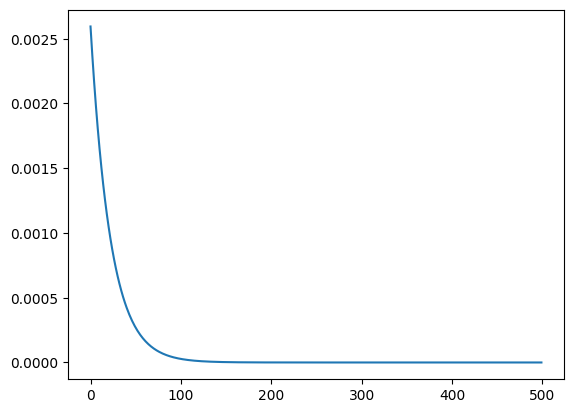

In [27]:
plt.plot(loss_values)

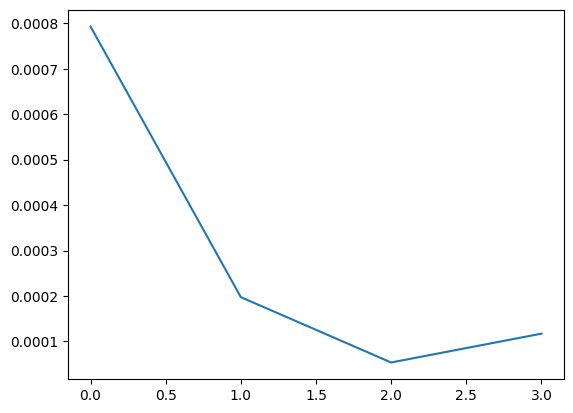

In [28]:
plt.plot(loss_values_tot)

In [29]:


for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.0996, 0.1044],
        [0.0996, 0.1044]], requires_grad=True)
Parameter containing:
tensor([0.1017, 0.1017], requires_grad=True)
Parameter containing:
tensor([[0.1057, 0.1057]], requires_grad=True)
Parameter containing:
tensor([0.1156], requires_grad=True)


In [30]:
# Testing

In [31]:
loss_values_test_tot=[]
for date in dates_test:
    print(date)
    print("Y ",len(df.loc[df['date']==date,'date'])/10000)
    loss_values_test = []
    for epoch in range(500):
        optimizer.zero_grad()

        Y=torch.FloatTensor([len(df.loc[df['date']==date,'date'])/10000])

        # get inputs
        temp=df.loc[df["date"]==date, "temperature"].mean()
        windspeed=df.loc[df["date"]==date, "wind_speed"].mean()

        X = torch.FloatTensor([temp,windspeed])
        Y_pred = model(X)

        loss = loss_fn(Y_pred, Y)

        #print("loss ", loss)
        
        loss_values_test.append(loss.item())
       
        #for param in model.parameters():
         #   print(param)
    print("loss " ,loss)
    loss_values_test_tot.append(sum(loss_values_test)/len(loss_values_test))

2013-07-01
Y  0.1361
loss  tensor(0.0005, grad_fn=<MseLossBackward0>)
2013-07-02
Y  0.0936
loss  tensor(0.0035, grad_fn=<MseLossBackward0>)
2013-07-03
Y  0.0885
loss  tensor(0.0034, grad_fn=<MseLossBackward0>)
2013-07-04
Y  0.2258
loss  tensor(0.0046, grad_fn=<MseLossBackward0>)


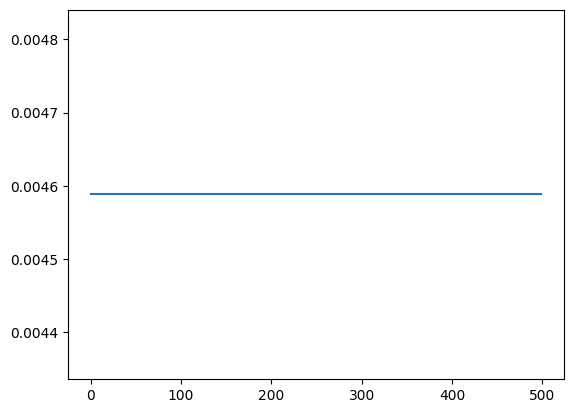

In [32]:
plt.plot(loss_values_test)

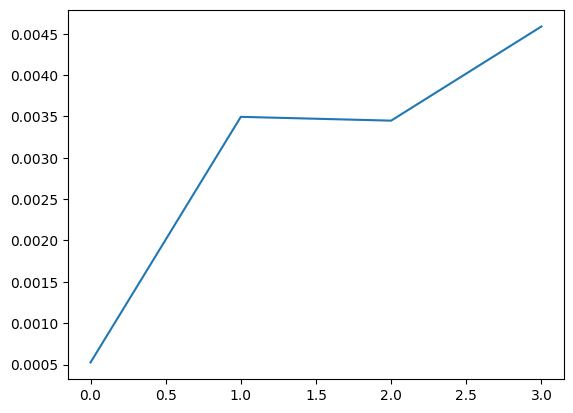

In [33]:
plt.plot(loss_values_test_tot)